In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

In [230]:
## remove rows with more than 7 na
## forward interpolate to fill missing data
## delete rows which still have NAs
def preprocess(df):
    df = df.dropna(thresh=7)
    df = df.replace(to_replace=0.0, value=np.nan)
    df = df.interpolate(method='linear', limit_direction='forward')
    df = df.dropna(thresh=7)
    df = df.interpolate(method='linear', limit_direction='backward')
    df = df.dropna(how='all')
    df['hour'] = df['timestamp'].apply(timestamp_to_hour)
    return df

## Normalize
def normalize(d):
    data_min = d.min(axis=0)
    data_max = d.max(axis=0)
    data_norm = (d - data_min) / (data_max - data_min)
    return data_norm, data_min, data_max 

## extract hour from timestamp
def timestamp_to_hour(ts):
    return datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').hour

def timestamp_to_yday(ts):
    return datetime.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').timetuple().tm_yday

## group variables for same quantity together
def group_features(columns):
    var_mapping = {}
    for col in columns:
        red_col = re.sub('\d', 'k', col)
        var_mapping[red_col] = var_mapping.get(red_col, [])
        var_mapping[red_col].append(col)

    del var_mapping['timestamp']
    return var_mapping

def create_features(data):
    columns = data.columns.to_list()
    ## Create new data frame with similar quantities summed up 
    var_mapping = group_features(columns)
    mean_data = {}
    # mean_data['timestamp'] = data['timestamp']
    for var in var_mapping:
        mean_data[var] = data[var_mapping[var]].sum(axis=1)

    md = pd.DataFrame(mean_data)
    # Compute PUE
    md['pue'] = md[['CH_k_POWER', 'EM/MDB k PAHU/TOTAL_POWER', 'PDU/ZkSk PDU k/TOTAL_POWER']].sum(axis=1) / md['PDU/ZkSk PDU k/TOTAL_POWER']
    return md

def train_model(md_norm, params, training_features, target_features):
    train_data = md_norm.sample(frac=0.7)
    valid_data = md_norm.sample(frac=0.2)
    test_data = md_norm.sample(frac=0.1)
    d_training = lgb.Dataset(train_data[training_features], label=train_data[target_features], free_raw_data=False)
    d_valid = lgb.Dataset(valid_data[training_features], label=valid_data[target_features], free_raw_data=False)

    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training, d_valid], verbose_eval=None, early_stopping_rounds=5000)
    return model

In [237]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 25,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}
training_features = [
                 'PDU/ZkSk PDU k/TOTAL_POWER', 
                 'oatk', 
                 'oah', 
                 'hour',
                 'CH_k/Evaporator Saturation Temp']

target_features = ['HUMIDITY_SENSOR/ZkSk_PDU_HUMI_k',
       'TEMP_SENSOR/ZkSk_PDU_TEMP_k', 'EM/MDB k PAHU/TOTAL_POWER',
       'SF/Zk PAHU k/SUP_TEMP', 'SF/Zk PAHU k/FAN_SPEED',
       'SF/Zk PAHU k/VALVE_OUT', 'SF/Zk PAHU k/RETURN_TEMP', 
       'PDU/ZkSk PDU k/TOTAL_POWER', 'CT k-k/TOTAL_POWER',
       'CH_k_SUPPLY', 'CW_k_SUPPLY', 'CH_k/Evaporator Saturation Temp',
       'CONDENSER PUMP k/TOTAL_POWER', 'CH_k_RETURN',
       'SECONDARY PUMP k/TOTAL_POWER', 'CW_k_RETURN', 'CH_k_POWER',
       'CWP_k_POWER', 'PDU/ZONE_k/DC_TOTAL_LOAD', 'PDU/ZONE_k/PUE', 'oatk',
       'oah', 'HT_EM/TOTAL_KW/TOTAL_kF', 'hour',
       'pue']

In [232]:
data = pd.read_csv('flat_df.csv')
data = preprocess(data)
md = create_features(data)
md_norm, md_min, md_max = normalize(md)

In [238]:
models = {}
for target in target_features:
    model = train_model(md_norm, params, training_features, [target])
    models[target] = model

HUMIDITY_SENSOR/ZkSk_PDU_HUMI_k


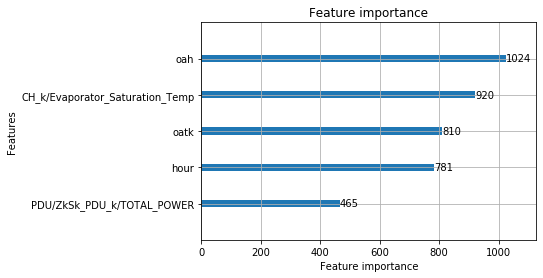

TEMP_SENSOR/ZkSk_PDU_TEMP_k


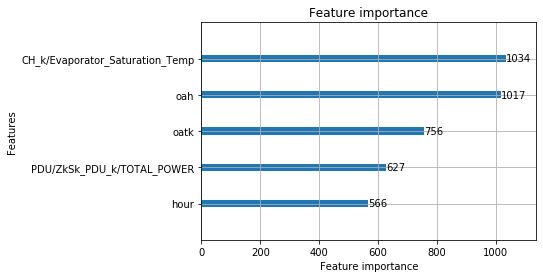

EM/MDB k PAHU/TOTAL_POWER


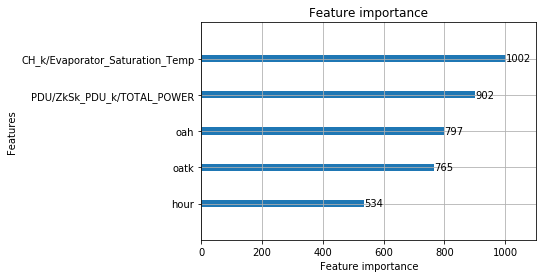

SF/Zk PAHU k/SUP_TEMP


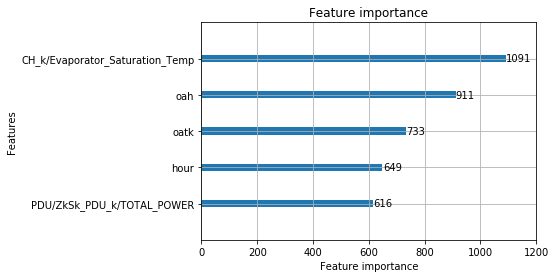

SF/Zk PAHU k/FAN_SPEED


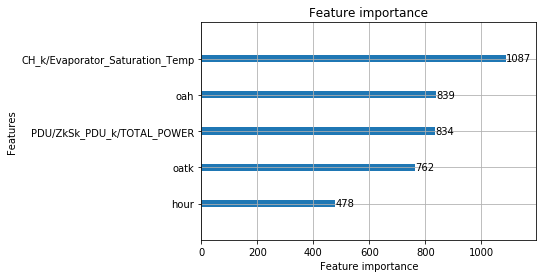

SF/Zk PAHU k/VALVE_OUT


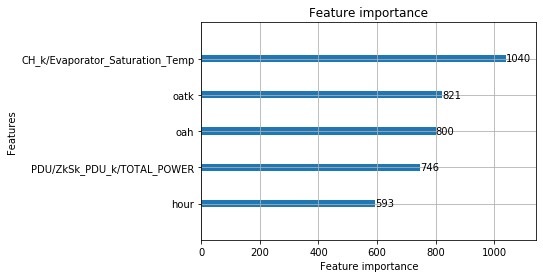

SF/Zk PAHU k/RETURN_TEMP


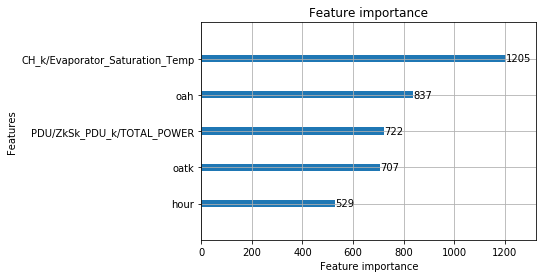

PDU/ZkSk PDU k/TOTAL_POWER


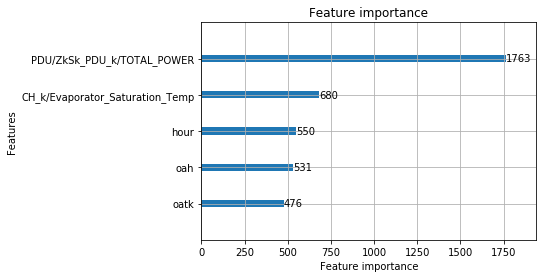

CT k-k/TOTAL_POWER


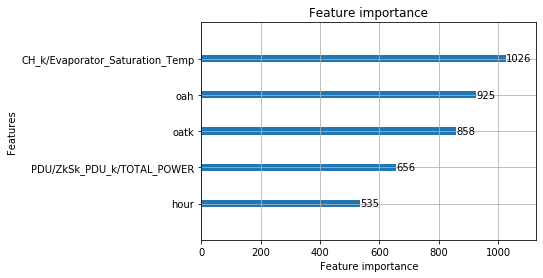

CH_k_SUPPLY


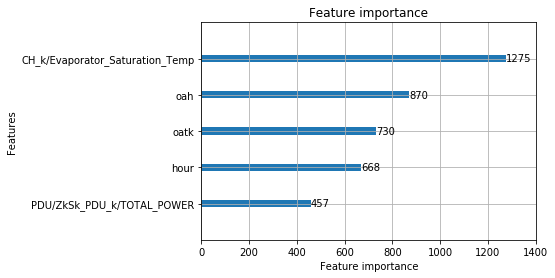

CW_k_SUPPLY


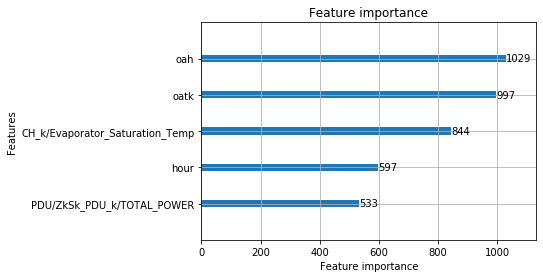

CH_k/Evaporator Saturation Temp


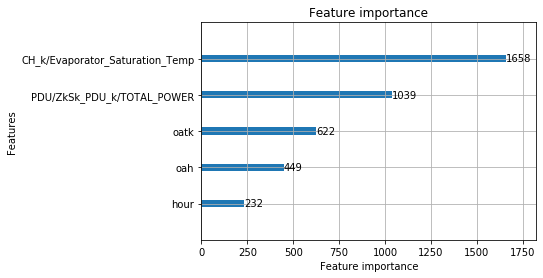

CONDENSER PUMP k/TOTAL_POWER


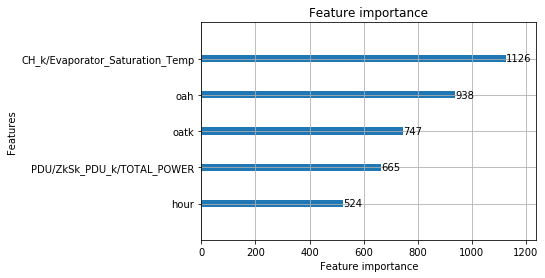

CH_k_RETURN


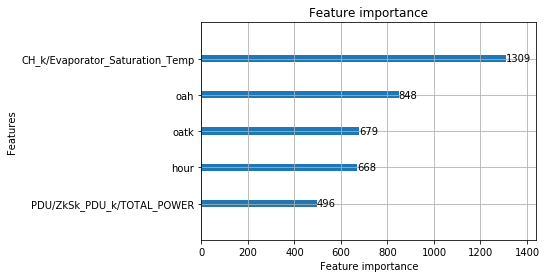

SECONDARY PUMP k/TOTAL_POWER


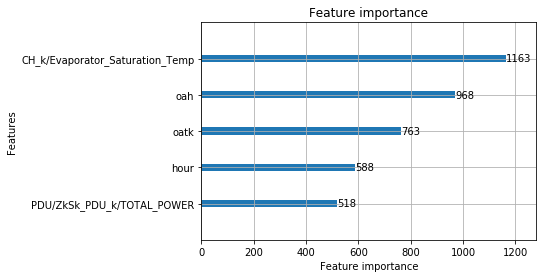

CW_k_RETURN


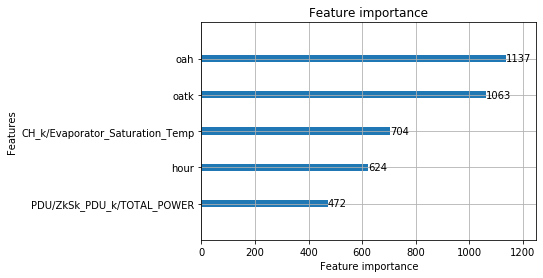

CH_k_POWER


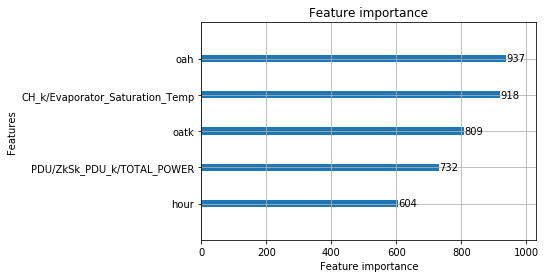

CWP_k_POWER


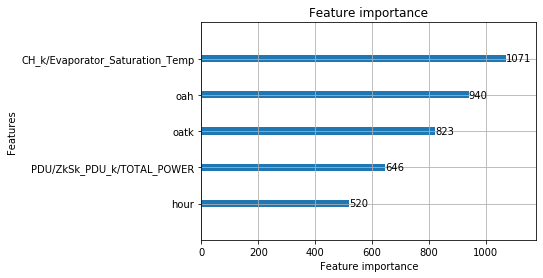

PDU/ZONE_k/DC_TOTAL_LOAD


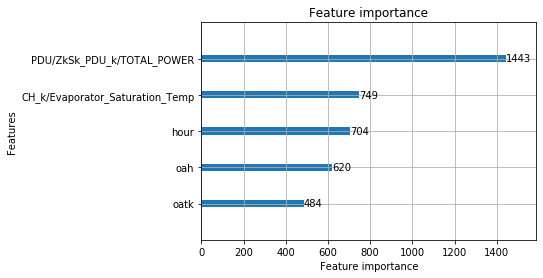

PDU/ZONE_k/PUE


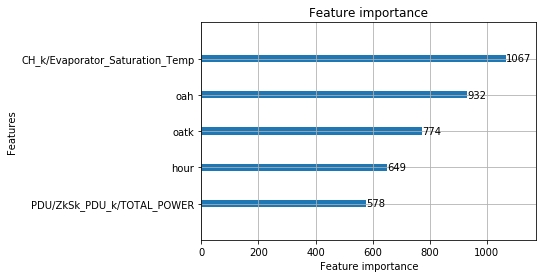

oatk


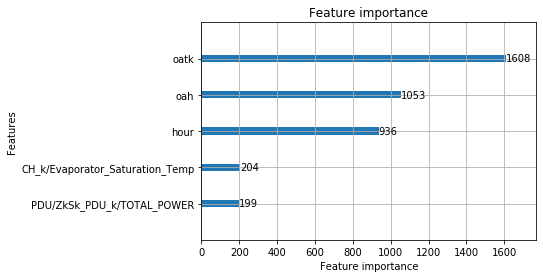

oah


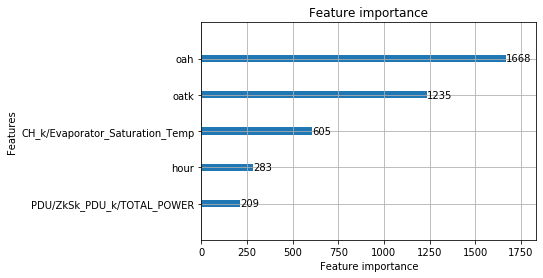

HT_EM/TOTAL_KW/TOTAL_kF


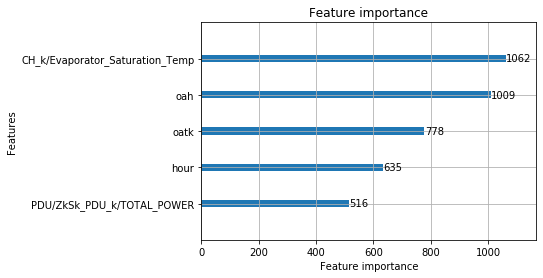

hour


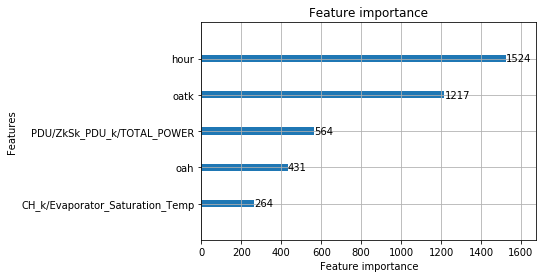

pue


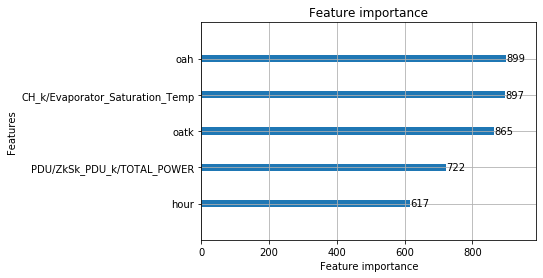

In [236]:
for target in target_features:
    print(target)
    model = models[target]
    lgb.plot_importance(model)
    plt.show()

# res = model.predict(md_norm[training_features])
# md_norm['pred_pue'] = res
# sns.lineplot(data=md_norm[['pred_pue', 'SF/Zk PAHU k/FAN_SPEED']].tail(20000))

In [212]:
md_norm['day'] = data['timestamp'].apply(timestamp_to_yday)

In [213]:
all_features = target_features + training_features
time_slice = md_norm[md_norm['day'] == 1][all_features].reset_index()

days = list(set(md_norm['day'].values))
for i in days:
    time_slice += md_norm[md_norm['day'] == i][all_features].reset_index()
time_slice = time_slice / len(days)

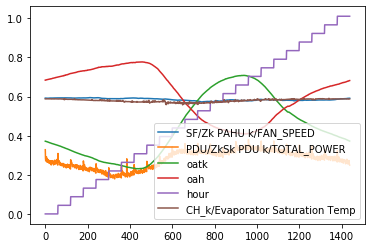

In [214]:
sns.lineplot(data=time_slice[all_features], dashes=False)

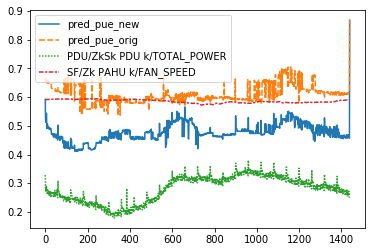

In [217]:
time_slice_2 = time_slice.copy()
oat_oah_pairs = []
for i in range(1, 15):
    oat = time_slice['oatk'].head(i * 100).values[-1]
    oah = time_slice['oah'].head(i * 100).values[-1]
    oat_oah_pairs.append((oat, oah))


res = model.predict(time_slice_2[training_features])
time_slice_2['pred_pue_orig'] = res


time_slice_2['CH_k/Evaporator Saturation Temp'] = time_slice['CH_k/Evaporator Saturation Temp'] + 0.1

res = model.predict(time_slice_2[training_features])
time_slice_2['pred_pue_new'] = res

sns.lineplot(data=time_slice_2[['pred_pue_new', 'pred_pue_orig', 'PDU/ZkSk PDU k/TOTAL_POWER', 'SF/Zk PAHU k/FAN_SPEED']])

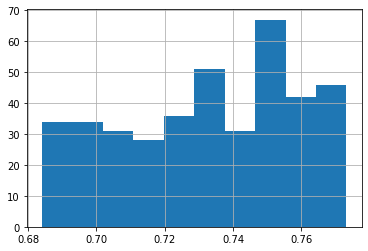

In [176]:
time_slice['oah'].head(400).hist()

In [201]:
md_norm.columns

Index(['ZkSk_PDU_TEMP_k', 'HUMIDITY_SENSOR/ZkSk_PDU_HUMI_k',
       'TEMP_SENSOR/ZkSk_PDU_TEMP_k', 'EM/MDB k PAHU/TOTAL_POWER',
       'SF/Zk PAHU k/SUP_TEMP', 'SF/Zk PAHU k/FAN_SPEED',
       'SF/Zk PAHU k/VALVE_OUT', 'SF/Zk PAHU k/RETURN_TEMP', 'Zk-PAHU-k_RA_SP',
       'Zk-PAHU-k_SA_SP', 'PDU/ZkSk PDU k/TOTAL_POWER', 'CT k-k/TOTAL_POWER',
       'CH_k_SUPPLY', 'CW_k_SUPPLY', 'CH_k/Evaporator Saturation Temp',
       'CONDENSER PUMP k/TOTAL_POWER', 'CH_k_RETURN',
       'SECONDARY PUMP k/TOTAL_POWER', 'CW_k_RETURN', 'CH_k_POWER',
       'CWP_k_POWER', 'PDU/ZONE_k/DC_TOTAL_LOAD', 'PDU/ZONE_k/PUE', 'oatk',
       'oah', 'SF/Zk PAHU k/SA_SET_POINT', 'HT_EM/TOTAL_KW/TOTAL_kF', 'hour',
       'pue', 'pred_pue'],
      dtype='object')

In [208]:
md_norm

,ZkSk_PDU_TEMP_k,HUMIDITY_SENSOR/ZkSk_PDU_HUMI_k,TEMP_SENSOR/ZkSk_PDU_TEMP_k,EM/MDB k PAHU/TOTAL_POWER,SF/Zk PAHU k/SUP_TEMP,SF/Zk PAHU k/FAN_SPEED,SF/Zk PAHU k/VALVE_OUT,SF/Zk PAHU k/RETURN_TEMP,Zk-PAHU-k_RA_SP,Zk-PAHU-k_SA_SP,...,CWP_k_POWER,PDU/ZONE_k/DC_TOTAL_LOAD,PDU/ZONE_k/PUE,oatk,oah,SF/Zk PAHU k/SA_SET_POINT,HT_EM/TOTAL_KW/TOTAL_kF,hour,pue,pred_pue
0,0.296,0.869639,0.550376,0.557784,0.607064,0.621440,1.000000,0.297730,1.0,NaN,...,0.850316,0.202454,0.811321,0.563910,0.703857,NaN,0.816492,0.0,0.572059,0.395786
1,0.296,0.868311,0.554887,0.555874,0.606623,0.621854,1.000000,0.297997,1.0,NaN,...,0.849693,0.105521,0.823899,0.563910,0.703857,NaN,0.816492,0.0,0.588730,0.362072
2,0.296,0.866224,0.557895,0.543457,0.606181,0.622268,1.000000,0.298264,1.0,NaN,...,0.849070,0.095706,0.823899,0.563910,0.703857,NaN,0.816492,0.0,0.586453,0.356344
3,0.288,0.869260,0.544361,0.541547,0.605740,0.622683,1.000000,0.298531,1.0,NaN,...,0.848448,0.111247,0.823899,0.563910,0.703857,NaN,0.816492,0.0,0.585737,0.362530
4,0.296,0.868121,0.551880,0.549188,0.605298,0.623097,1.000000,0.298798,1.0,NaN,...,0.847825,0.087526,0.823899,0.563910,0.703857,NaN,0.816492,0.0,0.596319,0.356344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131035,0.424,0.447818,0.580451,0.500478,0.291391,0.577939,0.973154,0.236315,1.0,NaN,...,0.423601,0.289162,0.836478,0.503759,0.550964,NaN,0.820183,1.0,0.615741,0.515926
131036,0.432,0.445161,0.586466,0.502388,0.291391,0.577939,0.973154,0.236315,1.0,NaN,...,0.423601,0.297342,0.830189,0.503759,0.550964,NaN,0.816275,1.0,0.615234,0.525145
131037,0.432,0.447059,0.574436,0.498567,0.291391,0.577939,0.973154,0.236315,1.0,NaN,...,0.423601,0.287526,0.830189,0.503759,0.550964,NaN,0.815884,1.0,0.612363,0.531875
131038,0.424,0.448387,0.580451,0.499522,0.291391,0.577939,0.973154,0.236315,1.0,NaN,...,0.423601,0.283436,0.830189,0.503759,0.555096,NaN,0.814668,1.0,0.615995,0.512921
